<a href="https://colab.research.google.com/github/neotee314/siamese-network-face-recognition/blob/main/Siamese_Network_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python--headless

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 55.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install albumentations


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 87.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 82.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 65.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 87.4 MB/s eta 0:00:0000:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
optuna 3.0.5 requires scipy<1.9.0,>=1.7.0, but you have scipy 1.10.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# **1 Dataloader**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from sklearn.utils import shuffle
import shutil
import tarfile
import random
import albumentations as A

class Data_loader:

    def __init__(self):
        pass

    def extract_tar_gz(self, archive_path, extract_path):
        with tarfile.open(archive_path, 'r:gz') as tar:
            tar.extractall(path=extract_path)

    def create_new_dataset(self, extract_path, new_dataset_path,num_images = 5):
        if not os.path.exists(new_dataset_path):
            os.makedirs(new_dataset_path)

        # Durchlaufen der Subfolder in lfw und Auswahl derer mit mindestens zwei Bildern
        for root, dirs, files in os.walk(extract_path[:-3]):
            if len(files) >= num_images:
                # Kopieren des Subfolders in das neue Dataset
                shutil.copytree(root, os.path.join(new_dataset_path, os.path.basename(root)))

        print("Neue Dataset wurde erstellt.")

    def create_face_image_with_label(self, dataset_path, num_of_person=10):
        face_images = []
        face_labels = []

        # Zufällig ausgewählte Unterordner
        selected_folders = random.sample(os.listdir(dataset_path), min(num_of_person, len(os.listdir(dataset_path))))

        # Durchlaufen der ausgewählten Unterordner
        for subfolder in selected_folders:
            subfolder_path = os.path.join(dataset_path, subfolder)

            # Durchlaufen der Bilder im Subfolder
            for filename in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, filename)

                # Lesen des Bildes und Hinzufügen zum face_images-Array
                image = cv2.imread(image_path)
                #Normalisieren
                if image.max()>1.0: image =image.astype(np.float32) / np.max(image)
                face_images.append(image)

                # Hinzufügen des Labels zum face_labels-Array
                face_labels.append(subfolder)

        # Konvertieren der Listen in NumPy-Arrays und Normalisieren
        face_images = np.array(face_images)
        face_labels = np.array(face_labels)

        return face_images,face_labels



    def perform_augmentation(self, face_images, face_labels, num_augmentations=4):
        augmented_images = []
        augmented_labels = []
        aug = A.Compose([
            A.HorizontalFlip(p=0.5),  # Horizontale Spiegelung
            A.RandomBrightnessContrast(p=0.2),  # Zufällige Helligkeit und Kontrast
            A.Rotate(limit=30, p=0.5),  # Rotation um zufälligen Winkel
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),  # Verschiebung, Skalierung und Rotation
            A.RandomBrightnessContrast(p=0.2),  # Zufällige Helligkeit und Kontrast
            A.RandomGamma(p=0.2),  # Zufällige Gamma-Anpassung
        ])

        for i, image in enumerate(face_images):
            label = face_labels[i]
            for _ in range(num_augmentations):
                augmented_image = aug(image=image)['image']
                augmented_images.append(augmented_image)
                augmented_labels.append(label)

        # Konvertiere die Listen in Numpy-Arrays
        augmented_images = np.array(augmented_images)
        augmented_labels = np.array(augmented_labels)

        return augmented_images, augmented_labels
    import numpy as np




    def generate_image_pairs(self, face_images, face_labels):
        unique_labels = np.unique(face_labels)
        label_wise_indices = dict()
        for label in unique_labels:
            label_wise_indices.setdefault(label,
                                          [index for index, curr_label in enumerate(face_labels) if
                                           label == curr_label])

        images_dataset = []
        labels_dataset = []
        for index, image in enumerate(face_images):
            pos_indices = label_wise_indices.get(face_labels[index])
            pos_image = face_images[np.random.choice(pos_indices)]
            images_dataset.append((image, pos_image))
            labels_dataset.append(1)

            neg_indices = np.where(face_labels != face_labels[index])[0]
            neg_image = face_images[np.random.choice(neg_indices)]
            images_dataset.append((image, neg_image))
            labels_dataset.append(0)

        images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)
        return np.array(images_dataset), np.array(labels_dataset)

    def visualize(self, image_pairs, n=5, title=""):
        def show(ax, image):
            ax.imshow(image)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        fig = plt.figure(figsize=(5, 5))
        plt.title(title)
        axs = fig.subplots(n, 2)
        for i in range(n):
            k = np.random.randint(0, image_pairs.shape[0]-1)
            img1 = cv2.cvtColor(image_pairs[k][0] , cv2.COLOR_BGR2RGB)
            img2 = cv2.cvtColor(image_pairs[k][1], cv2.COLOR_BGR2RGB)
            show(axs[i, 0], img1)
            show(axs[i, 1], img2)

    def visualize_positive_examples(self, image_dataset, label_dataset, n=5):
        indices = np.where(label_dataset == 1)[:n]
        self.visualize(image_dataset[indices],
                        n, title="Positive Image Examples")

    def visualize_negative_examples(self, image_dataset, label_dataset, n=5):
        indices = np.where(label_dataset == 0)[:n]
        self.visualize(image_dataset[indices], n,
                        title="Negative Image Examples")


# **2 Siamese Network**

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Concatenate, Lambda
from keras.applications.vgg16 import VGG16
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import keras
from keras.initializers import TruncatedNormal
from keras.callbacks import LearningRateScheduler



# Building the Siamese Network
class L1Dist(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))


class Siamese_Network:

    def __init__(self, input_shape, loss="contrastive_loss",initial_learning_rate = 0.001):
        self.initial_learning_rate = initial_learning_rate
        anchor_input = layers.Input(shape=input_shape)
        compare_input = layers.Input(shape=input_shape)

        # VGG model
        #vgg_model = VGG16(weights="imagenet", include_top=False)
        #for layer in vgg_model.layers:
         #   layer.trainable = False

        anchor_input_feature_map = self._create_embedding_model(anchor_input) # output = 1025 neuron
        compare_input_feature_map = self._create_embedding_model(compare_input) #output = 1025 neuron

        #anchor_input_feature_map = Flatten()(vgg_model(anchor_input))
        #compare_input_feature_map = Flatten()(vgg_model(compare_input))

        distance_func = Lambda(lambda t: K.abs(t[0] - t[1]))
        #distance_func = Lambda(lambda t: K.sqrt(K.maximum(K.sum(K.square(t[0] - t[1]), axis=1, keepdims=True), K.epsilon())))
        distance_layer = distance_func([anchor_input_feature_map, compare_input_feature_map]) #[0.2 0.3 0.4 ...]
        #siamese_layer= L1Dist()
        #distance_layer = siamese_layer(anchor_input_feature_map,compare_input_feature_map)

        prediction_layer = layers.Dense(1, activation="sigmoid")(distance_layer)

        self.siamese_model = Model(inputs=[anchor_input, compare_input], outputs=prediction_layer)

        opt = tf.keras.optimizers.Adam(initial_learning_rate)
        if loss == "contrastive_loss": loss = self.contrastive_loss
        self.siamese_model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

    def contrastive_loss(self, y_true, y_pred, margin=1.0):
        y_true = tf.cast(y_true, y_pred.dtype)
        squaredPreds = K.square(y_pred)
        squaredMargin = K.square(K.maximum(margin - y_pred, 0))
        loss =  0.5 *K.mean(y_true * squaredPreds + (1 - y_true) * squaredMargin)
        return loss

    def _create_embedding_vgg(self, inputs):
        #shape = inputs.shape
        vgg_model = VGG16(weights="imagenet", include_top=False, input_tensor=inputs)
        for layer in vgg_model.layers:
            layer.trainable = False
        output_tensor = vgg_model.output
        x = Flatten()(output_tensor)
        output_layer = Dense(1024, activation='sigmoid')(x)
        return output_layer, vgg_model

    def _create_embedding_model(self, inputs):
        # Add Gaussian noise layer
        x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        flatten_layer = layers.Flatten()(x)
        dense = layers.Dense(4096, activation="sigmoid")(flatten_layer)
        outputs = layers.Dense(1024, activation="sigmoid")(dense)
        return outputs


    def train(self,images_dataset,labels_dataset ,epochs=100,
              save=True, plot = True, summary=True , validation_split = 0.2, batch_size = 64):

        history = self.siamese_model.fit([images_dataset[:, 0,:,:], images_dataset[:, 1, :,:]], labels_dataset,
                                         epochs=epochs,
                                         validation_split = validation_split,
                                         batch_size = batch_size
                                         )#callbacks=[LearningRateScheduler(self.lr_scheduler)]

        if save:
            print("Speichern...", end="", flush=True)
            #self.siamese_model.save("/home/inf2642/BachelorArbeit/saved_siamese_model")
            self.siamese_model.save("/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/saved_models/saved_siamese_model")
            print("\nModell wurde erfolgreich gespeichert.")
        if plot:
            print("\nPlot training metrics...")
            self._plot_training_metrics(history)
        #if summary: history.summary()
        return history

    def _plot_training_metrics(self, history):
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.plot(history.history["accuracy"])
        plt.plot(history.history["val_accuracy"])
        plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])
        plt.xlabel("Epoch")
        plt.ylabel("Metrics")
        plt.title("Training Metrics")
        plt.show()


In [ ]:
X_train.shape

(6400, 2, 64, 64)

In [ ]:
len(X_train)

6400

In [ ]:
for idx in range(len(X_train[:1])):
    anchor_input, compare_input, labels = X_train[idx][0,:], X_train[idx][1,:], y_train[idx]
    #loss = self.train_step(anchor_input, compare_input, labels)
    #progbar.update(idx + 1, [("Loss", loss)])
    print(anchor_input.shape)
    print(compare_input.shape)
    print(labels)


(64, 64)
(64, 64)
0


# **4 Contrastive Loss Funktion**

In [ ]:
import tensorflow.keras.backend as K

#loss = (1 - y_true) * 0.5 * y_preds^2 + y_true * 0.5 * max(0, margin - y_preds)^2
#y_true = [y_i]  y_i =  1 für positive Matches und y_i =  0 für negative Matches
#y_pred = [y_i]  y_i€[0,1]

def contrastive_loss(y_true, y_preds, margin=1.0):
    y = tf.cast(y_true, y_preds.dtype)#datentype anpassen
    squaredPreds = K.square(y_preds)
    squaredMargin = K.square(K.maximum(margin - y_preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

# **3 Visualisierung von Dataset**

### **Entpacken der Daten und Erstellen der neuen Daten**

In [ ]:
# Pfad zum gzipped tar-Archiv
#archive_path = '/home/inf2642/BachelorArbeit/lfw.gz'
archive_path = '/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/datenbank/lfw.gz'
#extract_path = '/home/inf2642/BachelorArbeit/'
extract_path = '/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/datenbank/'
#new_dataset_path = '/home/inf2642/BachelorArbeit/lfw_new'
new_dataset_path = '/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/datenbank/lfw_new'
loader = Data_loader()
loader.extract_tar_gz(archive_path,extract_path)
loader.create_new_dataset(archive_path, new_dataset_path)



Neue Dataset wurde erstellt.


In [ ]:
new_dataset_path = '/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/datenbank/lfw_new'
extract_path = '/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/datenbank/lfw'
loader = Data_loader()
loader.create_new_dataset(extract_path, new_dataset_path)

FileExistsError: [Errno 17] File exists: '/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/datenbank/lfw_new/Wen_Jiabao'

In [ ]:
face_labels[:4]

array(['Erik_Morales', 'Erik_Morales', 'Erik_Morales', 'Demi_Moore'],
      dtype='<U16')

### **3.1 Plotting Positive images**

In [ ]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np

#dataset_path = '/home/inf2642/BachelorArbeit/lfw_new'
dataset_path = '/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/datenbank/lfw_new'
loader = Data_loader()

olivetti = fetch_olivetti_faces()
face_images = np.array(olivetti.images)
face_labels = np.array(olivetti.target)
face_images, face_labels = loader.perform_augmentation(face_images,face_labels,num_augmentations=20)
#face_images, face_labels = loader.create_face_image_with_label(dataset_path, num_of_person = 20)

In [ ]:
#face_images, face_labels = loader.perform_augmentation(face_images,face_labels,2)

In [ ]:
images_dataset, labels_dataset= loader.generate_image_pairs(face_images, face_labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pair.shape[0]

1

1 1


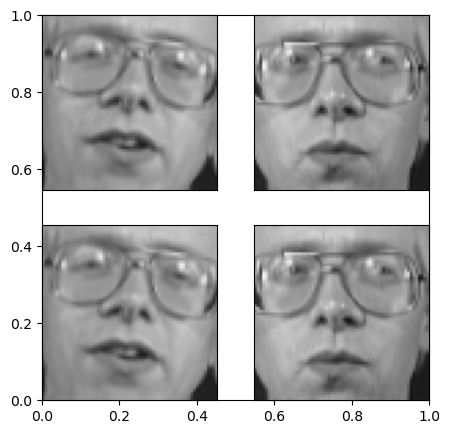

In [ ]:
pair = []

i =41
j = i+9
print(face_labels[i],face_labels[j])

pair.append((face_images[i],face_images[j]))
pair.append((face_images[i],face_images[j]))
pair = np.array(pair)
loader.visualize(pair, n=2, title="")

In [ ]:
def count_images_per_person(face_labels, num_of_person =5):
    i = 0
    unique_labels, counts = np.unique(face_labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"Person {label} hat {count} Bilder.")
        if i>num_of_person : break
        i+=1
# Beispielaufruf
count_images_per_person(face_labels)


Person 0 hat 200 Bilder.
Person 1 hat 200 Bilder.
Person 2 hat 200 Bilder.
Person 3 hat 200 Bilder.
Person 4 hat 200 Bilder.
Person 5 hat 200 Bilder.
Person 6 hat 200 Bilder.


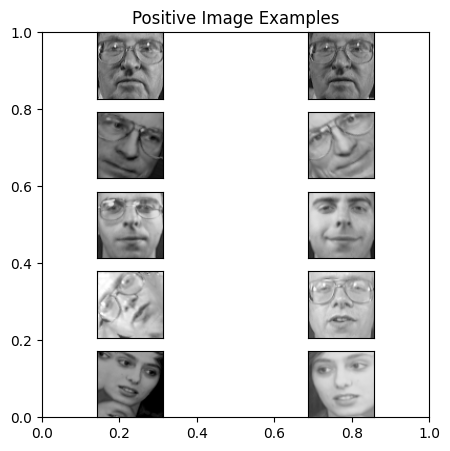

In [ ]:
loader.visualize_positive_examples(images_dataset, labels_dataset,n = 5)

### **3.1 Plotting Negative images**

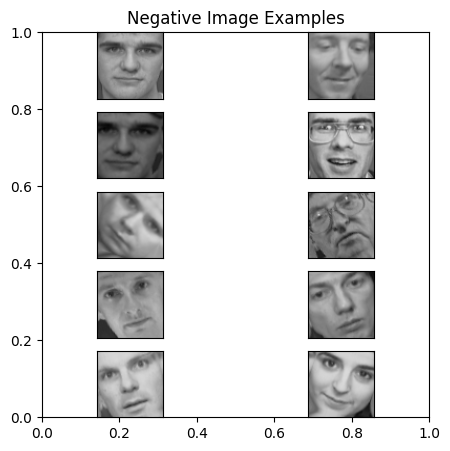

In [ ]:
loader.visualize_negative_examples(images_dataset, labels_dataset)

## **Anzahl Data in Dataset**

In [ ]:
images_dataset.shape

(16000, 2, 64, 64)

# **Training**

In [ ]:
import os
import shutil

#file_path = "/home/inf2642/BachelorArbeit/saved_siamese_model"
#file_path = "/home/inf2642/BachelorArbeit/lfw"
file_path = "/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/saved_models/saved_siamese_model"
#file_path = "/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/datenbank/lfw_new"
def delete_directory(path):
    try:
        shutil.rmtree(path)
        print(f"Directory {path} and its contents have been successfully deleted.")
    except Exception as e:
        print(f"Error deleting directory {path}: {e}")


delete_directory(file_path)



Directory /content/drive/MyDrive/Colab Notebooks/BachelorArbeit/saved_models/saved_siamese_model and its contents have been successfully deleted.


In [ ]:
X_train[0,0].shape +(1,)

(64, 64, 1)

In [ ]:
images_dataset[0,0].shape

(64, 64)

In [ ]:
images_dataset.shape

(2810, 2, 250, 250, 3)

In [ ]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
from sklearn.utils import shuffle
from keras.layers import *
from sklearn.model_selection import train_test_split
if __name__ == "__main__":
    EPOCHS = 150
    dataset_path = '/home/inf2642/BachelorArbeit/lfw_new'


    # Dataset vorbereiten
    loader = Data_loader()
    #face_images, face_labels = loader.create_face_image_with_label(dataset_path)
    #images_dataset, labels_dataset= loader.generate_image_pairs(face_images, face_labels)

    #olivetti = fetch_olivetti_faces()
    #face_images = np.array(olivetti.images)#(400,64,64)
    #face_labels = np.array(olivetti.target)
    #images_dataset, labels_dataset= loader.generate_image_pairs(face_images, face_labels)

    num_shuffles = 5000

    # Erstelle einen Array von Indizes
    num_samples = len(images_dataset)
    indices = np.arange(num_samples)

    # Mische die Indizes 5000 Mal
    for _ in range(num_shuffles):
      np.random.shuffle(indices)

    # Verwende die gemischten Indizes, um die Datensätze zu mischen
    images_dataset = images_dataset[indices]
    labels_dataset = labels_dataset[indices]

    # Initialisierung des Siamese_Networks
    siamese_network = Siamese_Network(input_shape = images_dataset[0,0].shape+(1,),
                                      loss = "binary_crossentropy",
                                      initial_learning_rate = 0.001) #(250,250,3)

    # Training des Siamese_Networks
    siamese_network.train(images_dataset,labels_dataset,
                          epochs = EPOCHS)

Epoch 1/150
200/200 [==============================] - 32s 107ms/step - loss: 0.6946 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.4963
Epoch 2/150
200/200 [==============================] - 20s 99ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6933 - val_accuracy: 0.4963
Epoch 3/150
200/200 [==============================] - 20s 100ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6931 - val_accuracy: 0.5038
Epoch 4/150
200/200 [==============================] - 20s 98ms/step - loss: 0.6933 - accuracy: 0.4972 - val_loss: 0.6931 - val_accuracy: 0.5038
Epoch 5/150
200/200 [==============================] - 19s 96ms/step - loss: 0.6933 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.5038
Epoch 6/150
200/200 [==============================] - 19s 97ms/step - loss: 0.6933 - accuracy: 0.4934 - val_loss: 0.6931 - val_accuracy: 0.5038
Epoch 7/150
200/200 [==============================] - 19s 97ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6931 - val_

# **7 Testing**

In [ ]:
def visualize_image_pairs(image_pairs, n, title="Bildervergleiche"):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig, axs = plt.subplots(n, 3, figsize=(5, 5))
    fig.suptitle(title)
    for i in range(n):
        test_image, image, score = image_pairs[i]  # Tuple aus Testbild, Bild und Score
        show(axs[i, 0], test_image)  # Testbild
        show(axs[i, 1], image)  # Bild
        axs[i, 2].text(0.5, 0.5, f"Score: {score:.4f}", fontsize=10, ha='left', va='center')  # Score
        axs[i, 2].axis('off')  # Keine Achsen anzeigen
    plt.show()


### **7.1 Vergleich eines Bildes mit einer Gruppe von Bildern**

1/1 [==============================] - 1s 539ms/step


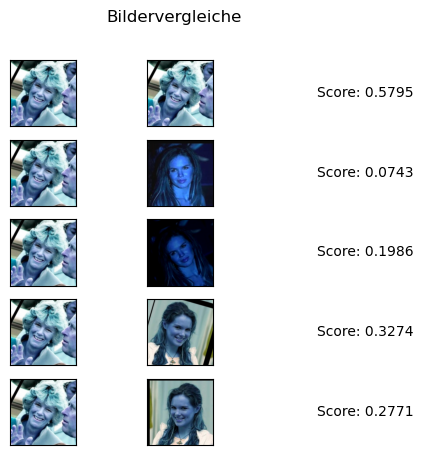

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import random

if __name__ == "__main__":

    # Laden des gespeicherten Modells
    saved_model_path = "/home/inf2642/BachelorArbeit/saved_siamese_model"
    #saved_model_path = "/content/saved_siamese_model"
    siamese_model = load_model(saved_model_path)
    #siamese_model = load_model(saved_model_path, custom_objects={"contrastive_loss":contrastive_loss })

    # Daten laden
    #olivetti = fetch_olivetti_faces()  # Laden der Daten
    #face_images = np.array(olivetti.images)  # Gesichtsbilder
    #face_labels = olivetti.target  # Gesichtslabels

    # Auswahl eines Testbildes zum Vergleich
    test_indices = [20, 30, 40, 35, 90]  # Indizes für Testbilder
    test_index = random.sample(range(20, 400), 1)[0]  # Zufälliger Index für ein Testbild
    test_image = face_images[test_index]  # Das ausgewählte Testbild

    # Auswahl mehrerer Bilder zum Vergleich mit dem Testbild
    compare_images = []
    for i in range(5):
      index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]  # Zufällige Auswahl eines Bildes aus jedem Intervall
      image = face_images[index]  # Ausgewähltes Bild
      compare_images.append(image)  # Hinzufügen zum Vergleich

    # Erstellen von Datensätzen (test_image, compare_image) für jedes compare_image
    # image_pairs = [[t,c1], [t,c2],[t,c3],...]
    image_pairs = []
    image_pairs.append((test_image,test_image))
    for image in compare_images:
        image_pairs.append((test_image, image))
    image_pairs = np.array(image_pairs)

    #################################################### Modelvorhersage ####################################################
    prediction = siamese_model.predict([image_pairs[:, 0], image_pairs[:, 1]])
    prediction = prediction.flatten()

    # Plotten der Ergebnisse
    image_paris_with_score = []
    for i, image in enumerate(image_pairs):
      image_paris_with_score.append((image[0], image[1],prediction[i]))
    visualize_image_pairs(image_paris_with_score, n = 5)  # Visualisierung


### **7.2 Vergleich zwei Bilder**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def normalize_image(image):
    if image.max() > 1.0 :
        normalized_image = image.astype(np.float32) / np.max(image)
    return normalized_image

def visualize_two_images(test_image, compare_image, score, title="Image Pair Examples"):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(title)
    show(axs[0], test_image)  # Testbild
    show(axs[1], compare_image)  # Bild
    axs[2].text(0.5, 0.5, f"Score: {score:.4f}", fontsize=10, ha='left', va='center')  # Score
    axs[2].axis('off')  # Deaktiviere die Achsen für den Score-Text
    plt.show()

In [ ]:
import cv2
import numpy as np
'''
image numpy (n,n,3)=> (1,n,n)
'''
def load_and_process_image(image, width = 200, height = 200):
    # Bild auf die gewünschte Ausgabegröße skalieren und in Graustufen konvertieren
    #image_resized = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    image_resized = cv2.resize(image,(width,height))
    #image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)  # Konvertieren in Graustufen
    # Schritt 1: Entfernen Sie die letzte Dimension
    #image_resized = np.squeeze(image_gray)  # (n,n) -> (n,n)
    # Schritt 2: Fügen Sie eine zusätzliche Achse hinzu
    #image_reshaped = np.expand_dims(image_resized, axis=0)  # (n,n) -> (1,n,n)
    image_reshaped = image_resized
    return np.array(image_reshaped)

In [ ]:
anchor_image = cv2.imread(anchor_path)

NameError: name 'anchor_path' is not defined

In [ ]:
anchor_image.shape

(194, 259, 3)

In [ ]:
pre_anchor = load_and_process_image(anchor_image)

In [ ]:
pre_anchor.shape

(200, 200, 3)

In [ ]:
X_train.shape

(210, 2, 250, 250, 3)

In [ ]:
import cv2

def compare_images(anchor_path, compare_path):
    # Laden der Bilder
    anchor_image = cv2.imread(anchor_path)  # (250,250,3)
    #anchor_image = cv2.cvtColor(anchor_image, cv2.COLOR_BGR2RGB)
    compare_image = cv2.imread(compare_path)
    #compare_image = cv2.cvtColor(compare_image, cv2.COLOR_BGR2RGB)

    # Vorverarbeitung der Bilder
    anchor_reshaped = load_and_process_image(anchor_image,X_train.shape[2],X_train.shape[3])  #(250, 250, 3)
    compare_reshaped = load_and_process_image(compare_image,X_train.shape[2],X_train.shape[3])

    # Überprüfe, ob die Bilder normalisiert sind
    anchor_reshaped = normalize_image(anchor_reshaped)#(250, 250, 3)
    compare_reshaped = normalize_image(compare_reshaped)#(250, 250, 3)
    print("max=", anchor_reshaped.max(), compare_reshaped.max())
    # Vorhersage mit dem Modell
    image_pairs = []
    image_pairs.append((anchor_reshaped,compare_reshaped))
    image_pairs = np.array(image_pairs)
    prediction = siamese_model.predict([image_pairs[:, 0], image_pairs[:, 1]])
    prediction = prediction.flatten()

    # Plotten des Ergebnisses
    visualize_two_images(anchor_reshaped, compare_reshaped, prediction[0])



max= 1.0 1.0
1/1 [==============================] - 0s 260ms/step


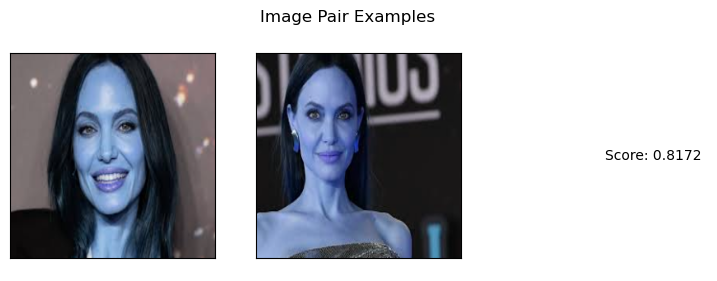

max= 1.0 1.0
1/1 [==============================] - 0s 93ms/step


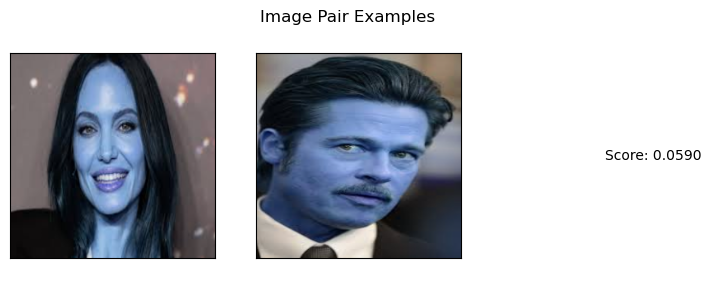

max= 1.0 1.0
1/1 [==============================] - 0s 95ms/step


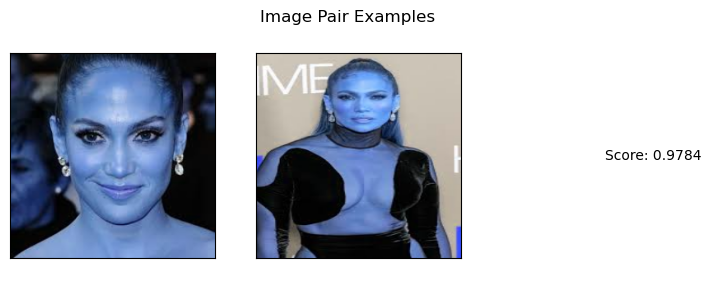

max= 1.0 1.0
1/1 [==============================] - 0s 96ms/step


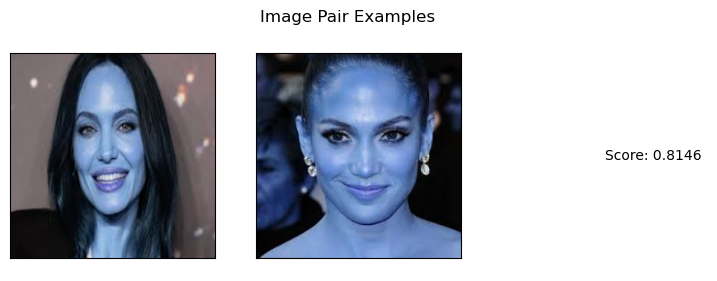

max= 1.0 1.0
1/1 [==============================] - 0s 95ms/step


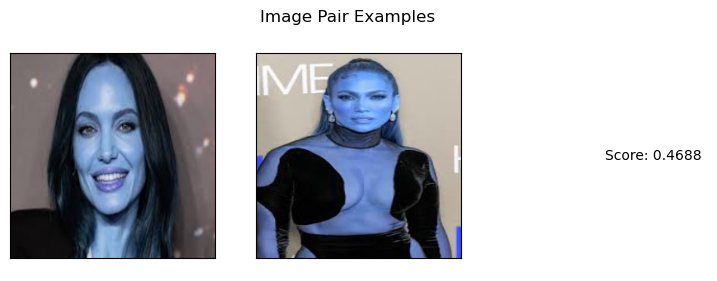

max= 1.0 1.0
1/1 [==============================] - 0s 96ms/step


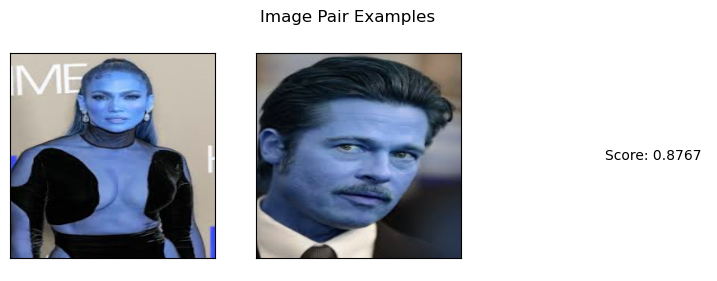

In [ ]:
if __name__ == "__main__":
    saved_model_path = "/home/inf2642/BachelorArbeit/saved_siamese_model"
    #saved_model_path = "/content/saved_siamese_model"
    siamese_model = load_model(saved_model_path)
    #anchor_path = "/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/compare_images/angelina/a1.jpeg"
    #compare_path1 = "/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/compare_images/angelina/a2.jpeg"
    #compare_path2 = "/content/drive/MyDrive/Colab Notebooks/BachelorArbeit/compare_images/bradpitt/b1.jpeg"

    anchor_path = "/home/inf2642/BachelorArbeit/test_images/angelina_jolie/a1.jpeg"
    compare_path1 = "/home/inf2642/BachelorArbeit/test_images/angelina_jolie/a2.jpeg"
    compare_path2 = "/home/inf2642/BachelorArbeit/test_images/brad_pit/b2.jpeg"
    compare_path3 = "/home/inf2642/BachelorArbeit/test_images/jennifer lopez/j1.jpeg"
    compare_path4 = "/home/inf2642/BachelorArbeit/test_images/jennifer lopez/j2.jpeg"
    compare_images(anchor_path, compare_path1)
    compare_images(anchor_path,compare_path2)
    compare_images(compare_path3,compare_path4)
    compare_images(anchor_path,compare_path3)
    compare_images(anchor_path,compare_path4)
    compare_images(compare_path4,compare_path2)
